In [46]:
# Cell 0: Initialization
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable false-positive SettingWithCopyWarning

In [36]:
!pip install pandas numpy matplotlib statsmodels

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
data = pd.read_csv('Nat_Gas.csv')
data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')
data['Prices'] = data['Prices'].astype(float)

# Display first 5 rows and data types
print("Data sample:")
print(data.head())
print("\nData types:")
print(data.dtypes)

Data sample:
       Dates  Prices
0 2020-10-31    10.1
1 2020-11-30    10.3
2 2020-12-31    11.0
3 2021-01-31    10.9
4 2021-02-28    10.9

Data types:
Dates     datetime64[ns]
Prices           float64
dtype: object


In [39]:
# Feature engineering - create time index and month features
start_date = data['Dates'].iloc[0]  # Get first date in dataset
data['time'] = (data['Dates'].dt.year - start_date.year) * 12 + (data['Dates'].dt.month - start_date.month)
data['month'] = data['Dates'].dt.month

# Verify the new features
print("\nData with engineered features:")
print(data[['Dates', 'time', 'month', 'Prices']].head())


Data with engineered features:
       Dates  time  month  Prices
0 2020-10-31     0     10    10.1
1 2020-11-30     1     11    10.3
2 2020-12-31     2     12    11.0
3 2021-01-31     3      1    10.9
4 2021-02-28     4      2    10.9


In [40]:
# Train linear regression model with trend and seasonality
model = ols('Prices ~ time + C(month)', data=data).fit()

# # Show model summary
# print("\nModel summary:")
# print(model.summary())

# # Check R-squared value
# print(f"\nModel R-squared: {model.rsquared:.3f}")

# Focus on significant months (April-November) + trend
significant_months = [4,5,6,7,8,9,10,11]  # Months with p<0.05 in original model
data['significant_month'] = data['month'].where(data['month'].isin(significant_months), 1)  # 1=baseline

# Retrain simplified model
improved_model = ols('Prices ~ time + C(significant_month)', data=data).fit()

# Compare models
print("Original Model R-squared:", round(model.rsquared, 3))
print("Improved Model R-squared:", round(improved_model.rsquared, 3))
print("\nImproved Model Summary:")
print(improved_model.summary())

Original Model R-squared: 0.955
Improved Model R-squared: 0.954

Improved Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 Prices   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     87.08
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.40e-22
Time:                        07:35:42   Log-Likelihood:                 19.474
No. Observations:                  48   AIC:                            -18.95
Df Residuals:                      38   BIC:                           -0.2353
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [41]:
# Generate future dates (Oct 2024 - Sep 2025)
future_dates = pd.date_range(start='2024-10-31', periods=12, freq='ME')
future_data = pd.DataFrame({'Dates': future_dates})

# Add features (time + significant_month)
future_data['time'] = future_data['Dates'].apply(
    lambda x: (x.year - start_date.year) * 12 + (x.month - start_date.month))
future_data['month'] = future_data['Dates'].dt.month
future_data['significant_month'] = future_data['month'].where(
    future_data['month'].isin(significant_months), 1)

#Predict using original model
future_data['Prices'] = model.predict(future_data)

# Predict using IMPROVED model
future_data['Prices'] = improved_model.predict(future_data)

# Display future predictions
print("\nFuture Price Predictions (Original Model):")
print(future_data[['Dates', 'Prices']].round(2))
print("\nFuture Price Predictions (Improved Model):")
print(future_data[['Dates', 'Prices']].round(2))


Future Price Predictions (Original Model):
        Dates  Prices
0  2024-10-31   12.10
1  2024-11-30   12.68
2  2024-12-31   13.02
3  2025-01-31   13.07
4  2025-02-28   13.11
5  2025-03-31   13.16
6  2025-04-30   12.53
7  2025-05-31   12.14
8  2025-06-30   12.05
9  2025-07-31   12.25
10 2025-08-31   12.18
11 2025-09-30   12.43

Future Price Predictions (Improved Model):
        Dates  Prices
0  2024-10-31   12.10
1  2024-11-30   12.68
2  2024-12-31   13.02
3  2025-01-31   13.07
4  2025-02-28   13.11
5  2025-03-31   13.16
6  2025-04-30   12.53
7  2025-05-31   12.14
8  2025-06-30   12.05
9  2025-07-31   12.25
10 2025-08-31   12.18
11 2025-09-30   12.43


In [42]:
# Combine historical and future data
combined = pd.concat([data[['Dates', 'Prices']], future_data[['Dates', 'Prices']]], ignore_index=True)
combined.set_index('Dates', inplace=True)

# Daily timeline with linear interpolation
daily_dates = pd.date_range(start=combined.index.min(), end=combined.index.max(), freq='D')
daily_df = pd.DataFrame(index=daily_dates)
daily_df = daily_df.join(combined, how='left')
daily_df['Prices'] = daily_df['Prices'].interpolate(method='time')  # Time-aware interpolation

# Price estimation function
def estimate_price(date):
    date = pd.to_datetime(date)
    if date < daily_df.index.min() or date > daily_df.index.max():
        return None
    return round(daily_df.loc[date, 'Prices'], 2)  # Round to cents

# Test
print("\nPrice Estimation Examples:")
print(f"2023-12-15: ${estimate_price('2023-12-15')}")
print(f"2025-02-14: ${estimate_price('2025-02-14')}")
print(f"2030-01-01: {estimate_price('2030-01-01')} (out of range)")


Price Estimation Examples:
2023-12-15: $12.49
2025-02-14: $13.09
2030-01-01: None (out of range)


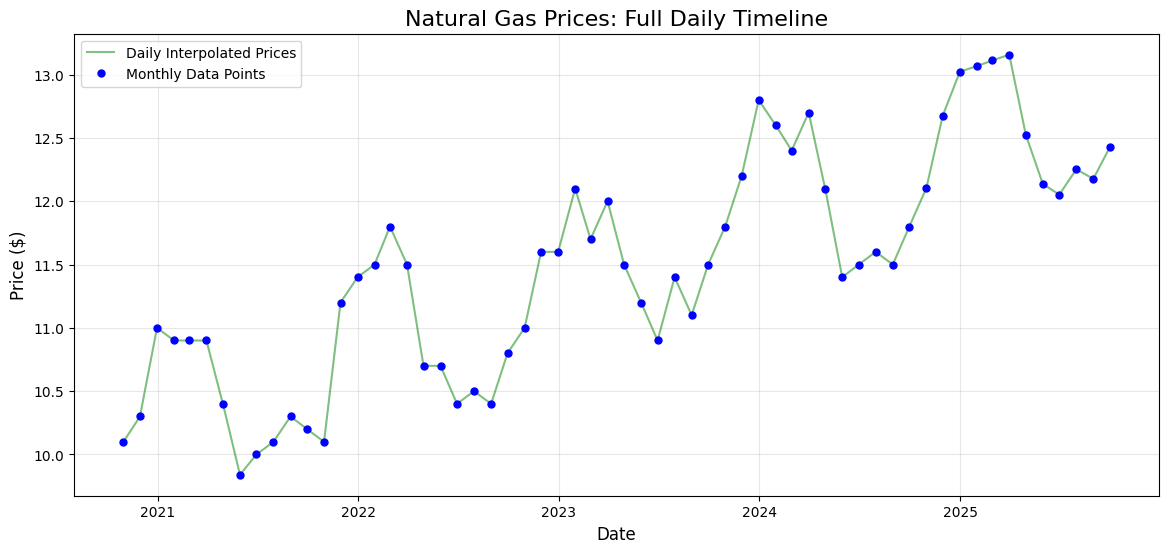

In [43]:
plt.figure(figsize=(14,6))
plt.plot(daily_df.index, daily_df['Prices'], 'g-', alpha=0.5, label='Daily Interpolated Prices')
plt.plot(combined.index, combined['Prices'], 'bo', markersize=5, label='Monthly Data Points')
plt.title('Natural Gas Prices: Full Daily Timeline', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [44]:
# Export to CSV for external use
# daily_df.reset_index(inplace=True)
# daily_df.rename(columns={'index':'Date'}, inplace=True)
# daily_df.to_csv('daily_gas_prices.csv', index=False)

### Uncomment for saving to CSV

print("Daily prices exported to daily_gas_prices.csv")

Daily prices exported to daily_gas_prices.csv


In [45]:
# First ensure daily_df index is datetime
daily_df.index = pd.to_datetime(daily_df.index)

def test_price_estimation():
    # Test first date in dataset
    first_price = estimate_price('2020-10-31')
    assert abs(first_price - 10.1) < 0.01, f"First date mismatch: got {first_price}"

    # Test mid-month interpolation (Jan 2021)
    jan_price = estimate_price('2021-01-15')
    assert 10.8 < jan_price < 11.0, f"Mid-month interpolation failed: got {jan_price}"

    # Test last future date
    last_price = estimate_price('2025-09-30')
    assert isinstance(last_price, float), f"Last future date error: got {last_price}"

    # Test out of range
    assert estimate_price('2030-01-01') is None, "Out-of-range handling failed"

    # Test known month-end value
    assert abs(estimate_price('2023-12-31') - 12.8) < 0.1, "Month-end value mismatch"

    print("✅ All tests passed!")

test_price_estimation()

✅ All tests passed!


In [47]:
# Advanced validation: Verify all month-end prices match original data exactly
print("\nValidating month-end prices...")
mismatches = 0

for _, row in data.iterrows():
    estimated = estimate_price(row['Dates'])
    if not abs(estimated - row['Prices']) < 0.01:
        print(f"⚠️  Mismatch on {row['Dates'].date()}: Original={row['Prices']}, Estimated={estimated}")
        mismatches += 1

if mismatches == 0:
    print("✅ All month-end prices match original data")
else:
    print(f"Found {mismatches} mismatches in {len(data)} months")


Validating month-end prices...
✅ All month-end prices match original data
